In [1]:
import os
import pandas as pd
import numpy as np
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [2]:
#Loading the y-paramter from file, might be changed to y_a etc.
y_a = pd.read_parquet('../Data_and_task/A/train_targets.parquet')
y_b = pd.read_parquet('../Data_and_task/B/train_targets.parquet')
y_c = pd.read_parquet('../Data_and_task/C/train_targets.parquet')

In [3]:
#Loading estimated/forecasted training_weather from file
X_estimated_a = pd.read_parquet('../Data_and_task/A/X_train_estimated.parquet')
X_estimated_b = pd.read_parquet('../Data_and_task/B/X_train_estimated.parquet')
X_estimated_c = pd.read_parquet('../Data_and_task/C/X_train_estimated.parquet')

In [4]:
#Loading observed weather from file
X_observed_a = pd.read_parquet('../Data_and_task/A/X_train_observed.parquet')
X_observed_b = pd.read_parquet('../Data_and_task/B/X_train_observed.parquet')
X_observed_c = pd.read_parquet('../Data_and_task/C/X_train_observed.parquet')

In [49]:
X_test_a = pd.read_parquet('../Data_and_task/A/X_test_estimated.parquet')
X_test_b = pd.read_parquet('../Data_and_task/B/X_test_estimated.parquet')
X_test_c = pd.read_parquet('../Data_and_task/C/X_test_estimated.parquet')

In [5]:
def resize_training_data(X_train, y_train):
    y_features = y_train.columns.tolist()
    X_date_feature = "date_forecast"
    
    merged = pd.merge(X_train, y_train,left_on=X_date_feature, right_on='time', how='inner')
    y_train_resized = merged[y_features]
    columns_to_drop = y_features + [X_date_feature]
    X_train_resized = merged.drop(columns = columns_to_drop)
    return X_train_resized, y_train_resized

# Lag

In [46]:
import pandas as pd

X_a = pd.concat([X_observed_a, X_estimated_a])
X_train, y_train = resize_training_data(X_a, y_a)

def feature_engineering(X, y, lags, window):
    """
    Perform feature engineering on X using values from y.
    """
    # Extract pv_measurement as the target variable
    y_target = y['pv_measurement']
    
    # Ensure the target has a name
    if y_target.name is None:
        y_target.name = 'target'
    
    # Combine X and y for easier lag and rolling window calculations
    df = pd.concat([X, y_target], axis=1)
    
    # Creating lag features
    for lag in lags:
        df[f'lag_{lag}'] = df[y_target.name].shift(lag)
    
    # Creating rolling window features
    df[f'rolling_mean_{window}'] = df[y_target.name].rolling(window=window).mean()
    df[f'rolling_std_{window}'] = df[y_target.name].rolling(window=window).std()
    
    # Drop NaN values which were introduced by lag and rolling window features
    df = df.dropna()
    
    # Separate the features and target variable
    X_engineered = df.drop(columns=[y_target.name])
    y_engineered = df[y_target.name]
    
    return X_engineered, y_engineered

# Now, you can call the function with your X_train and y_train DataFrames
X_train_engineered, y_train_engineered = feature_engineering(X_train, y_train, lags=[1, 2, 3], window=3)

In [47]:
X_train_engineered = X_train_engineered.drop(columns = ["date_calc"])

In [60]:
display(X_train_engineered)

absolute_humidity_2m:gm3  air_density_2m:kgm3  ceiling_height_agl:m  \
16676                       3.6                1.291           3935.100098   
16681                       2.4                1.314           3603.199951   
16682                       2.2                1.317           3556.199951   
16683                       2.1                1.317           4026.500000   
16684                       2.1                1.317           2508.399902   
...                         ...                  ...                   ...   
17377                       3.9                1.241           3440.300049   
17378                       4.1                1.240           7476.600098   
17379                       4.3                1.241           7202.500000   
17380                       4.3                1.242           4460.200195   
17381                       4.5                1.246           8125.899902   

       clear_sky_energy_1h:J  clear_sky_rad:W  cloud_base_agl:m  \
16676           0.000000e+00         0.000000        528.099976   
16681           0.000000e+00         0.000000       1352.199951   
16682           0.000000e+00         0.000000       1781.000000   
16683           2.189730e+04        14.900000       1902.000000   
16684           7.474290e+04        24.700001        972.400024   
...                      ...              ...               ...   
17377           1.422458e+06       371.500000       1077.900024   
17378           1.210754e+06       295.899994       3251.000000   
17379           8.888449e+05       194.699997       1168.599976   
17380           5.030874e+05        85.900002       1182.300049   
17381           1.562877e+05        10.900000       1977.599976   

       dew_or_rime:idx  dew_point_2m:K  diffuse_rad:W  diffuse_rad_1h:J  ...  \
16676              0.0      269.399994       0.000000          0.000000  ...   
16681              0.0      264.200012       0.000000          0.000000  ...   
16682              0.0      263.500000       0.000000          0.000000  ...   
16683              0.0      262.899994      14.800000      26592.599609  ...   
16684              0.0      262.899994      21.900000      66093.296875  ...   
...                ...             ...            ...               ...  ...   
17377              0.0      270.399994     142.199997     537476.500000  ...   
17378              0.0      271.000000     113.099998     459560.593750  ...   
17379              0.0      271.700012      93.199997     371215.593750  ...   
17380              0.0      271.799988      52.400002     262070.906250  ...   
17381              0.0      272.399994      10.800000     113806.296875  ...   

       visibility:m  wind_speed_10m:ms  wind_speed_u_10m:ms  \
16676  31458.000000                2.3                  1.7   
16681  20302.500000                2.9                  0.9   
16682  26865.099609                2.9                  0.9   
16683  32314.599609                2.9                  0.9   
16684  29288.400391                2.7                  1.0   
...             ...                ...                  ...   
17377  51039.601562                3.2                 -2.5   
17378  51062.699219                1.7                 -1.7   
17379  49285.300781                2.8                 -2.5   
17380  49750.800781                2.4                 -1.7   
17381  45862.699219                2.3                 -2.0   

       wind_speed_v_10m:ms  wind_speed_w_1000hPa:ms    lag_1    lag_2  \
16676                  1.6                     -0.0     0.22     8.58   
16681                  2.7                     -0.0     5.50     6.82   
16682                  2.8                     -0.0     1.98     5.50   
16683                  2.8                     -0.0    22.22     1.98   
16684                  2.5                     -0.0    87.56    22.22   
...                    ...                      ...      ...      ...   
17377                  2.0          

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Split the engineered features and target variable into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X_train_engineered, y_train_engineered, test_size=0.05, random_state=42)

# Instantiate and train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

/Users/simenfritzner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


RandomForestRegressor(random_state=42)

In [58]:
# Make predictions
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

def predict_sequentially(X_test, initial_y_lags, model):
    predictions = []
    y_lags = list(initial_y_lags)
    for i in range(len(X_test)):
        # Add y_lags to the X_test
        X_test_with_lags = np.append(X_test.iloc[i], y_lags[-1:])
        
        # Predict the next value
        prediction = model.predict([X_test_with_lags])[0]
        predictions.append(prediction)
        
        # Update y_lags with the predicted value
        y_lags.append(prediction)
        
    return predictions

# Assuming last_y_train_values contains the last few values from y_train
last_y_train_values = y_train.iloc[-3:].values


In [59]:
display(X_test)

absolute_humidity_2m:gm3  air_density_2m:kgm3  ceiling_height_agl:m  \
17326                       3.3                1.246           1990.300049   
16738                       2.6                1.308           6168.600098   
17378                       4.1                1.240           7476.600098   
16701                       4.9                1.252           1497.199951   
17349                       3.7                1.267           4275.100098   

       clear_sky_energy_1h:J  clear_sky_rad:W  cloud_base_agl:m  \
17326           1.322644e+06       382.899994       1371.099976   
16738           1.750620e+04        13.500000       5551.700195   
17378           1.210754e+06       295.899994       3251.000000   
16701           0.000000e+00         0.000000       1327.400024   
17349           1.380297e+06       398.799988        577.799988   

       dew_or_rime:idx  dew_point_2m:K  diffuse_rad:W  diffuse_rad_1h:J  ...  \
17326              0.0      267.899994     196.399994      690677.00000  ...   
16738              0.0      265.200012      15.400000       27740.00000  ...   
17378              0.0      271.000000     113.099998      459560.59375  ...   
16701              0.0      273.399994       0.000000           0.00000  ...   
17349              0.0      269.600006     189.500000      668900.00000  ...   

       visibility:m  wind_speed_10m:ms  wind_speed_u_10m:ms  \
17326  12723.599609                0.9                 -0.1   
16738  43855.398438                2.7                 -2.6   
17378  51062.699219                1.7                 -1.7   
16701  27472.900391                1.2                 -1.2   
17349  23952.099609                5.8                  4.7   

       wind_speed_v_10m:ms  wind_speed_w_1000hPa:ms   lag_1    lag_2    lag_3  \
17326                 -0.9                      0.0  489.94   694.10   317.24   
16738                  0.8                     -0.0   18.48    10.56   169.62   
17378                  0.3                     -0.0  698.06  1344.42  1215.94   
16701                  0.2                     -0.0   14.52    17.60    22.66   
17349                 -3.4                      0.0  286.44    99.00    60.06   

       rolling_mean_3  rolling_std_3  
17326      618.933333     112.219913  
16738       40.406667      45.011556  
17378      964.626667     337.728472  
16701       10.853333       9.148756  
17349      289.593333     192.189403  

[5 rows x 50 columns]

In [61]:
# Get the predictions
predictions = predict_sequentially(X_test, last_y_train_values, model)

/Users/simenfritzner/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


ValueError: X has 51 features, but RandomForestRegressor is expecting 50 features as input.

# Correlation

absolute_humidity_2m:gm3  air_density_2m:kgm3   -0.845102
                          dew_point_2m:K         0.989038
                          t_1000hPa:K            0.930255
air_density_2m:kgm3       dew_point_2m:K        -0.877776
                          msl_pressure:hPa       0.808395
                                                   ...   
lag_2                     lag_3                  0.743987
                          rolling_mean_3         0.862986
                          rolling_std_3          0.670946
lag_3                     rolling_mean_3         0.636282
rolling_mean_3            rolling_std_3          0.810305
Length: 85, dtype: float64


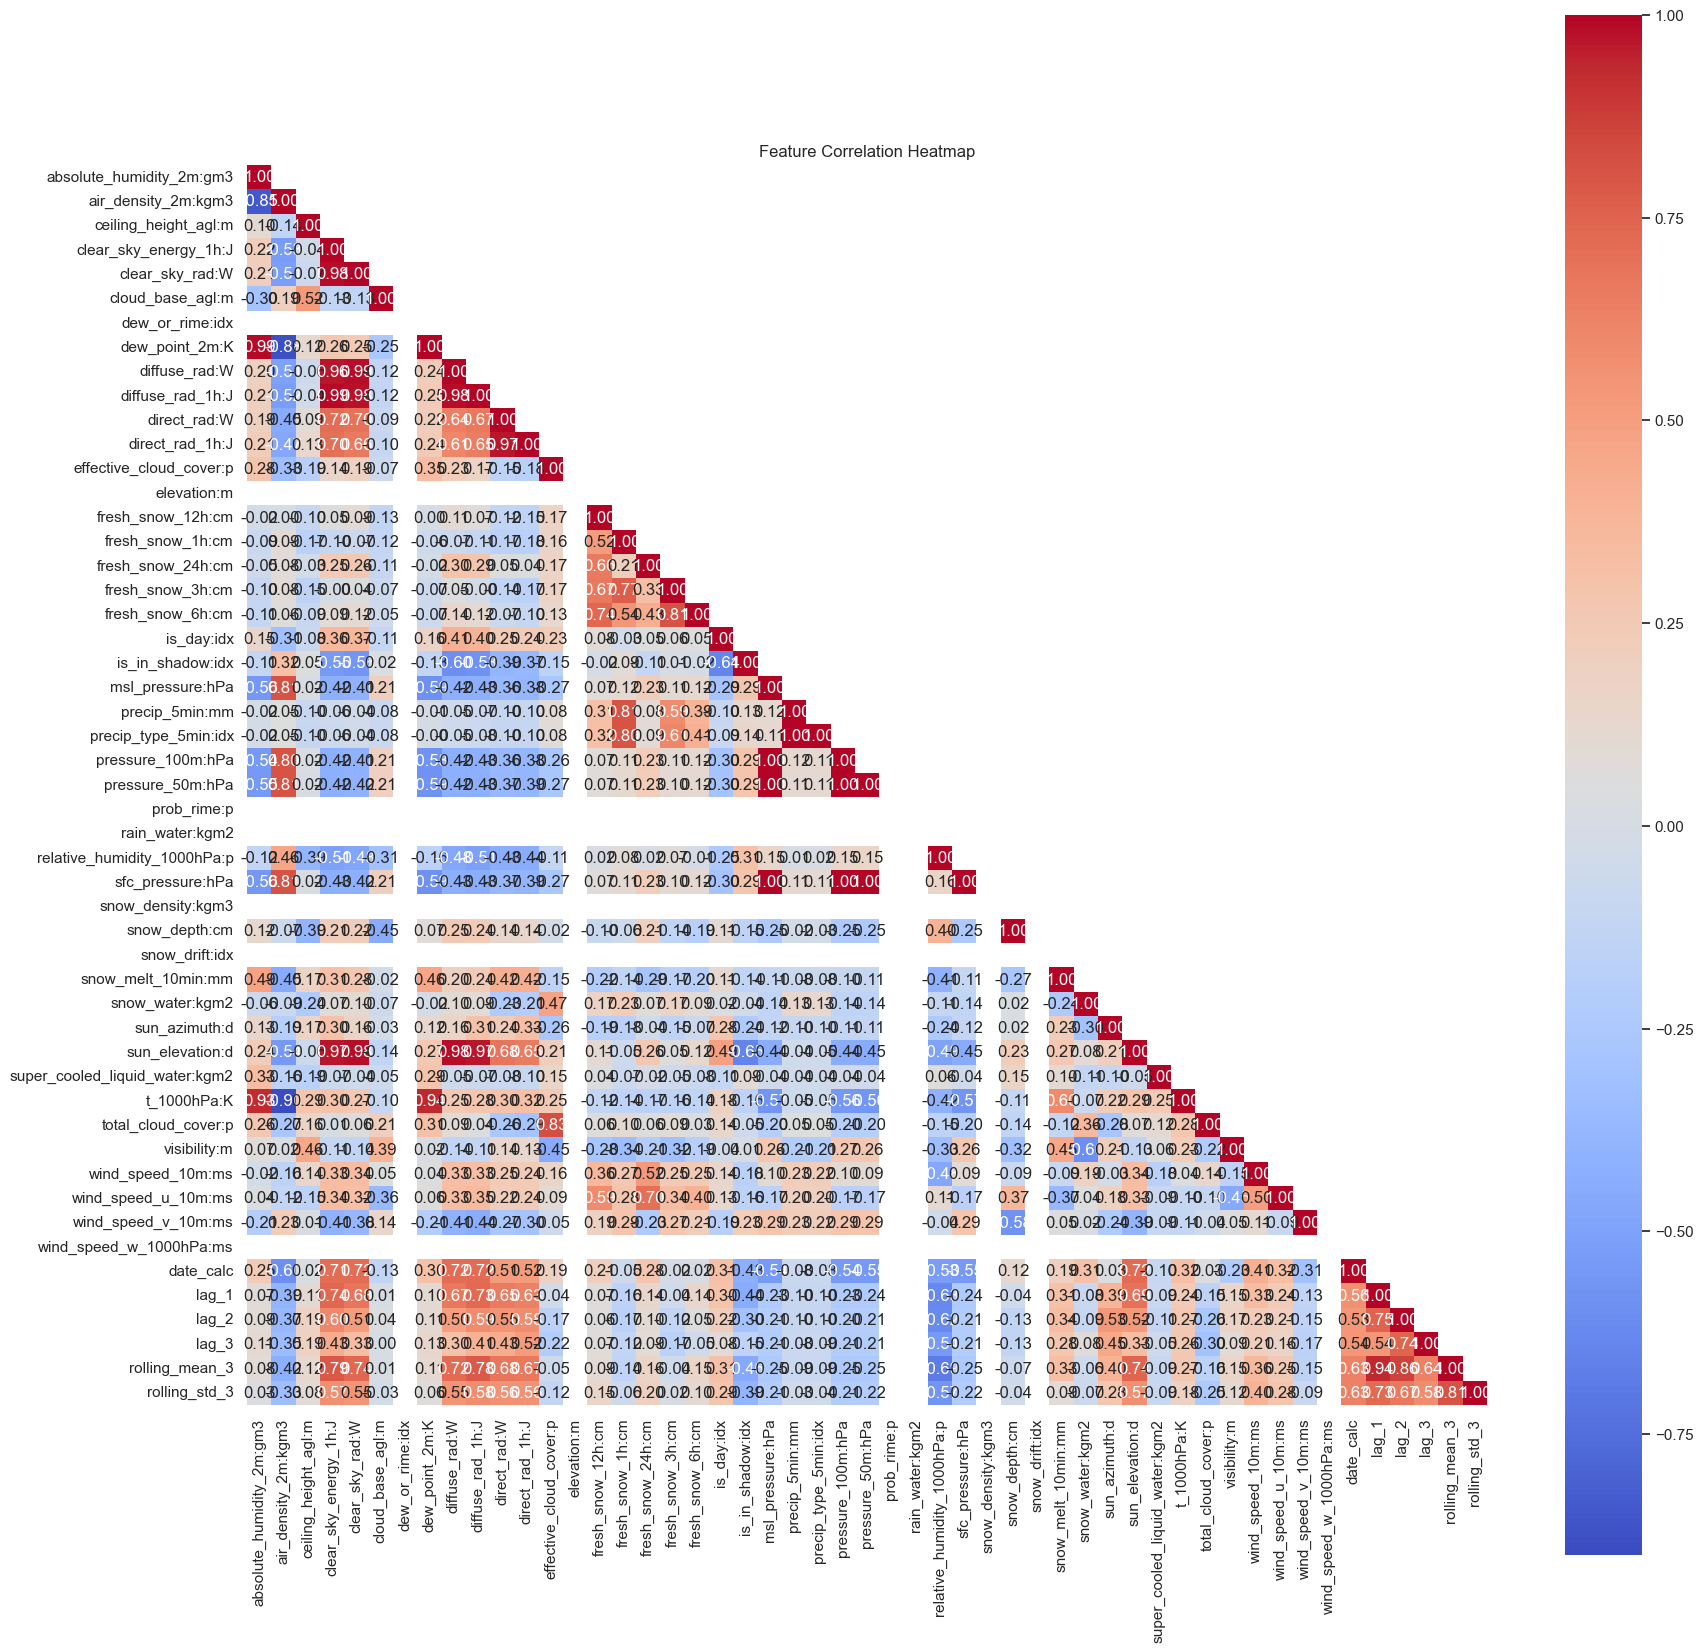

In [18]:
#Training, validation and test
"""X_train_observed_a = X_observed_a.drop(columns =["elevation:m", "snow_density:kgm3", "snow_drift:idx"]).copy()
X_train_estimated_a = X_estimated_a[:int(X_estimated_a.shape[0] * 3 / 4)].drop(columns =["elevation:m", "snow_density:kgm3", "snow_drift:idx"]).copy()
X_valid_estimated_a = X_estimated_a[int(X_estimated_a.shape[0] * 3 / 4):int(X_estimated_a.shape[0] * 9 / 10)].drop(columns =["elevation:m", "snow_density:kgm3", "snow_drift:idx"]).copy()
X_test_estimated_a = X_estimated_a[int(X_estimated_a.shape[0] * 9 / 10):].drop(columns =["elevation:m", "snow_density:kgm3", "snow_drift:idx"]).copy()

df = pd.concat([X_train_observed_a, X_train_estimated_a], ignore_index=True)"""

df = X_train_engineered

# Compute the correlation matrix
corr_matrix = df.corr()

# Create mask for upper triangle of the matrix
mask_upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

# Filter out correlations based on the range
strongly_correlated_pairs = corr_matrix.where(
    mask_upper & ((corr_matrix >= 0.6) | (corr_matrix <= -0.6))
).stack()

print(strongly_correlated_pairs)

# Plot the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", cbar=True, square=True, fmt='.2f', mask=mask_upper)
plt.title("Feature Correlation Heatmap")
plt.show()

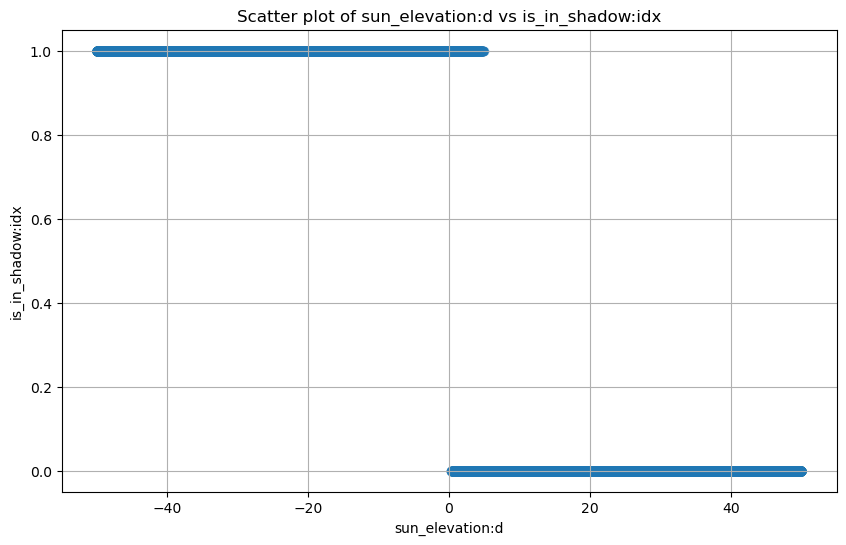

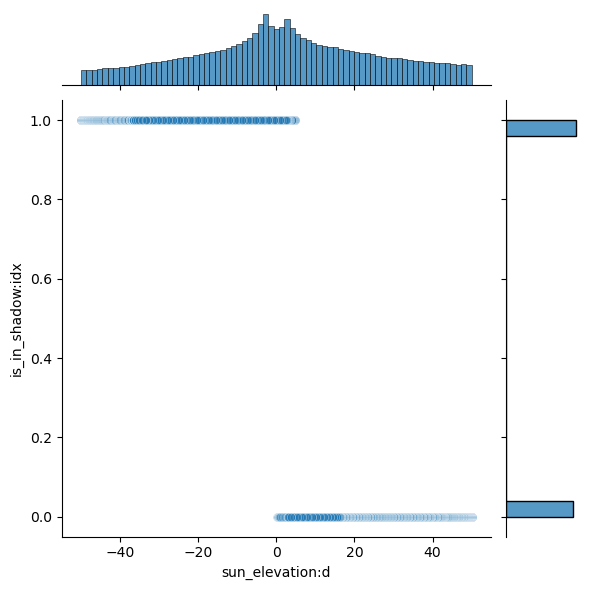

In [7]:
# Assuming df is your DataFrame
feature1 = "sun_elevation:d"  # Replace with the name of your first feature
feature2 = "is_in_shadow:idx"  # Replace with the name of your second feature

plt.figure(figsize=(10, 6))
plt.scatter(X_observed_a[feature1], X_observed_a[feature2], alpha=0.5)
plt.title(f"Scatter plot of {feature1} vs {feature2}")
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.grid(True)
plt.show()

sns.jointplot(data=X_observed_a, x=feature1, y=feature2, kind='scatter', joint_kws={'alpha':0.5})
plt.show()

# Checking for diffences in the datasets, min, max, mean

In [8]:
y_a = y_a[y_a['pv_measurement'] != 0]
statistics = y_a.describe()
print(statistics)

                             time  pv_measurement
count                       18045    18045.000000
mean   2021-04-26 01:05:44.139651     1191.123336
min           2019-06-03 02:00:00        0.220000
25%           2020-05-25 16:00:00      127.820000
50%           2021-05-15 02:00:00      599.940000
75%           2022-05-06 14:00:00     1838.980000
max           2023-04-30 19:00:00     5733.420000
std                           NaN     1378.401846


In [9]:
y_b = y_b[y_b['pv_measurement'] != 0]
statistics = y_b.describe()
print(statistics)

                             time  pv_measurement
count                       15536    15532.000000
mean   2020-10-31 11:38:48.784757      204.745881
min           2019-01-01 10:00:00        0.000208
25%           2019-10-22 09:45:00       28.939212
50%           2020-08-19 06:30:00      115.575000
75%           2021-08-07 10:15:00      276.000000
max           2023-04-30 19:00:00     1152.300000
std                           NaN      239.679247


In [10]:
y_c = y_c[y_c['pv_measurement'] != 0]
statistics = y_c.describe()
print(statistics)

                             time  pv_measurement
count                       16203    10143.000000
mean   2020-07-15 02:42:29.083503      199.722222
min           2018-12-31 23:00:00        0.980000
25%           2019-06-18 17:30:00       36.260000
50%           2020-06-01 04:00:00      117.600000
75%           2021-06-13 23:00:00      294.000000
max           2023-04-30 20:00:00      999.600000
std                           NaN      215.301692


# Scatterplots

In [11]:
"""# Assuming df_target has a single column named 'target'
target_column = 'pv_measurement'
df_features, df_target = resize_training_data(X_observed_a, y_a)

# Looping through each feature column in the DataFrame
for feature in df_features.columns:
    plt.figure(figsize=(6, 4))
    
    # Create a scatter plot for each feature vs the target
    plt.scatter(df_features[feature], df_target[target_column])
    
    # Adding title and labels
    plt.title(f'Scatterplot of {feature} vs {target_column}')
    plt.xlabel(feature)
    plt.ylabel(target_column)
    
    # Display the plot
    plt.show()"""

"# Assuming df_target has a single column named 'target'\ntarget_column = 'pv_measurement'\ndf_features, df_target = resize_training_data(X_observed_a, y_a)\n\n# Looping through each feature column in the DataFrame\nfor feature in df_features.columns:\n    plt.figure(figsize=(6, 4))\n    \n    # Create a scatter plot for each feature vs the target\n    plt.scatter(df_features[feature], df_target[target_column])\n    \n    # Adding title and labels\n    plt.title(f'Scatterplot of {feature} vs {target_column}')\n    plt.xlabel(feature)\n    plt.ylabel(target_column)\n    \n    # Display the plot\n    plt.show()"

# Seaborn scatterplots with lin_func

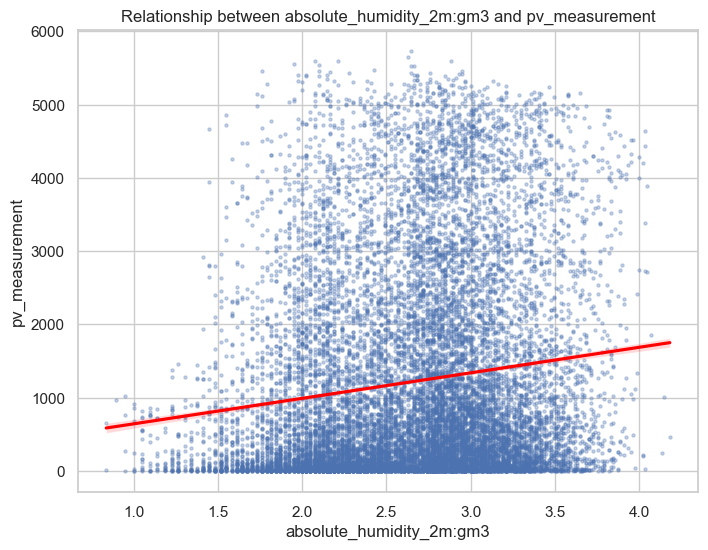

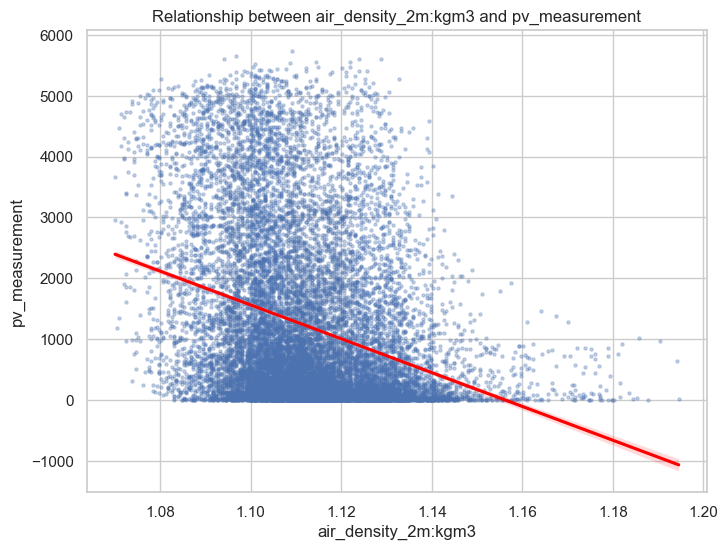

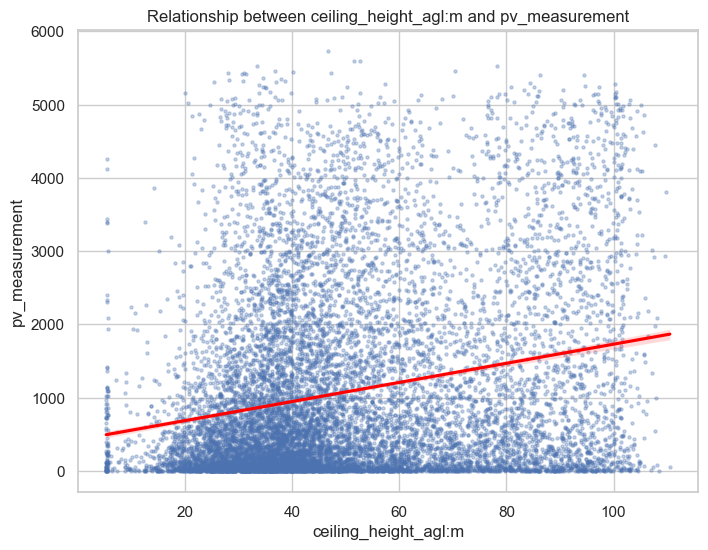

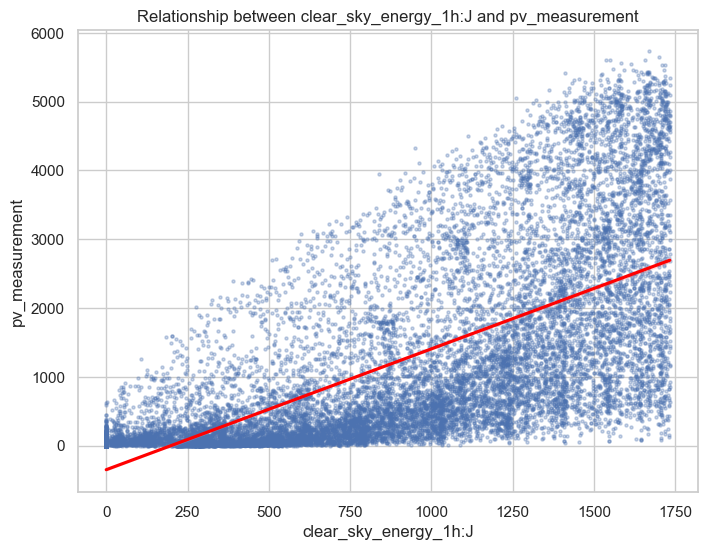

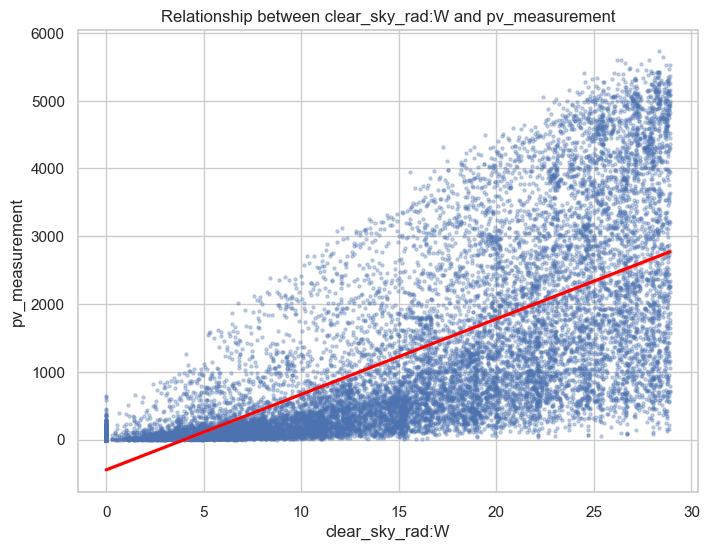

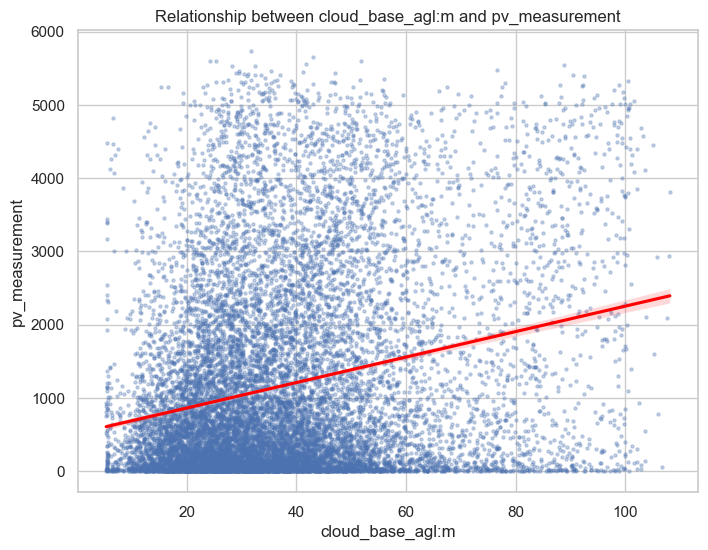

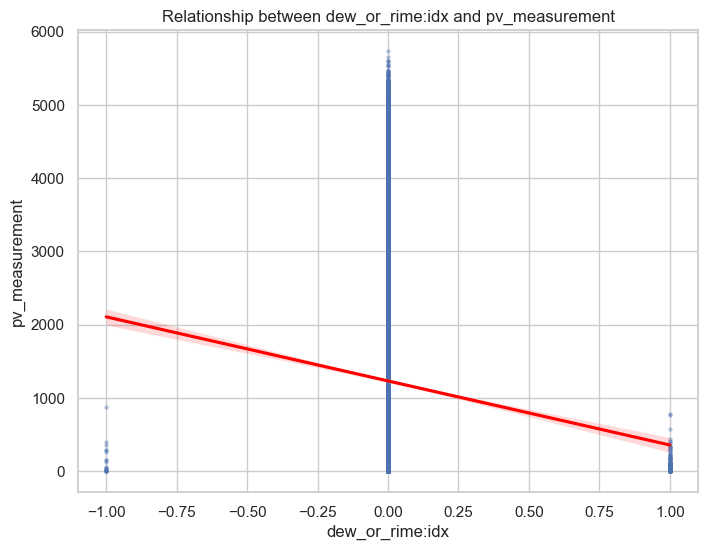

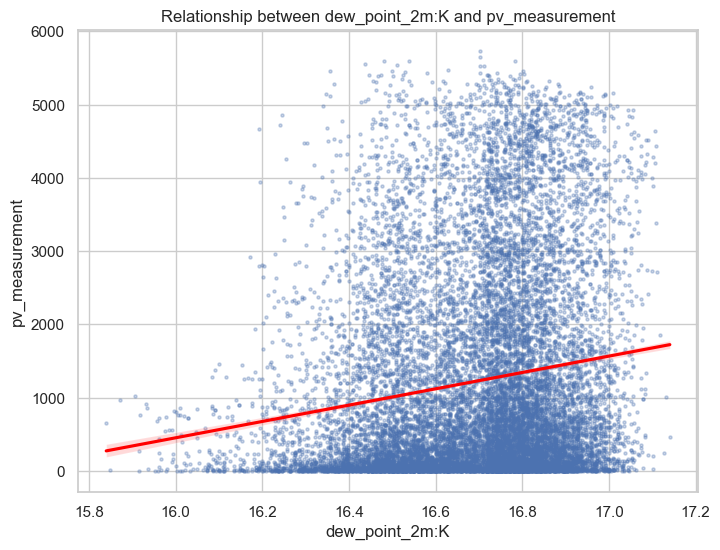

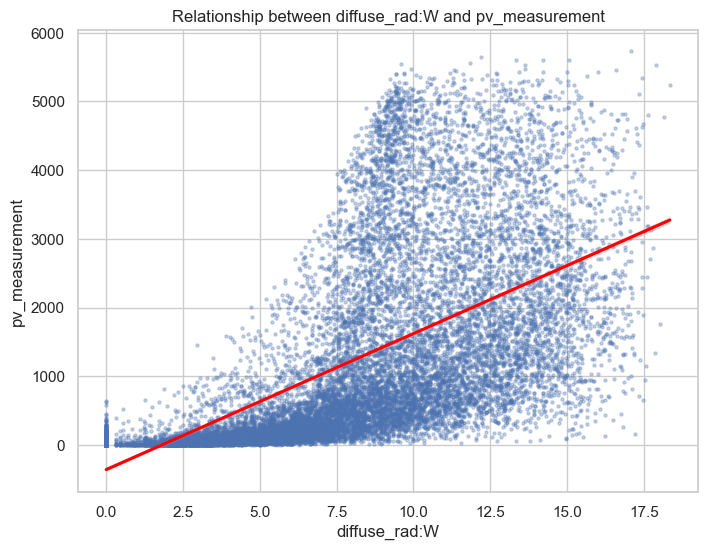

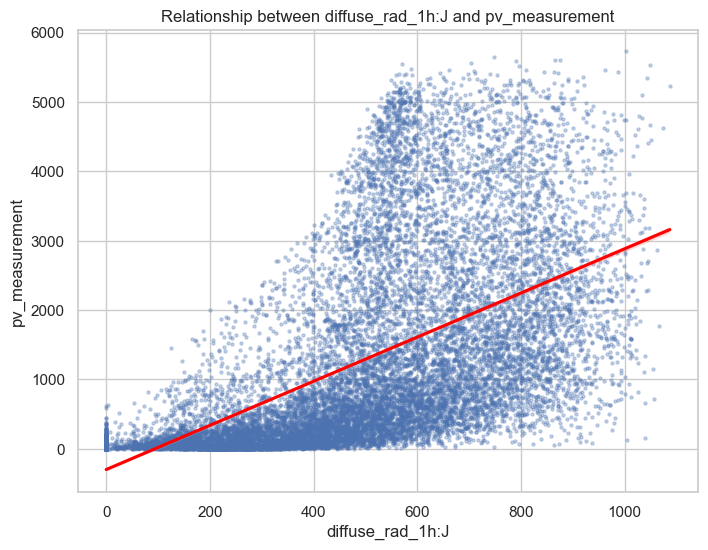

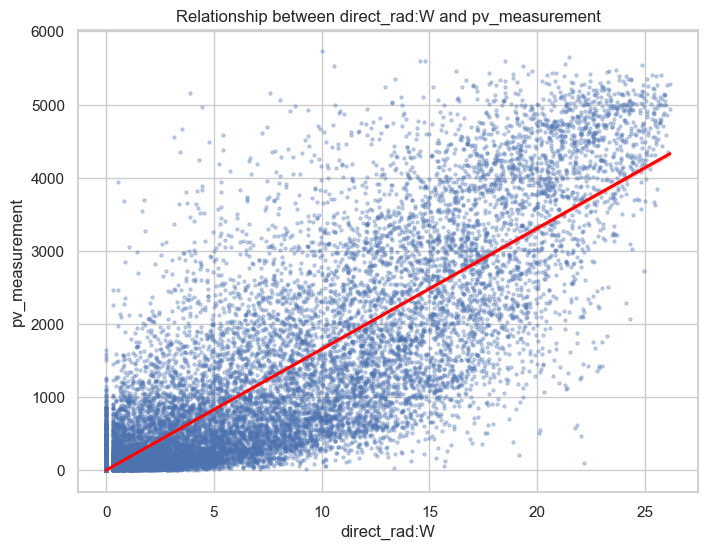

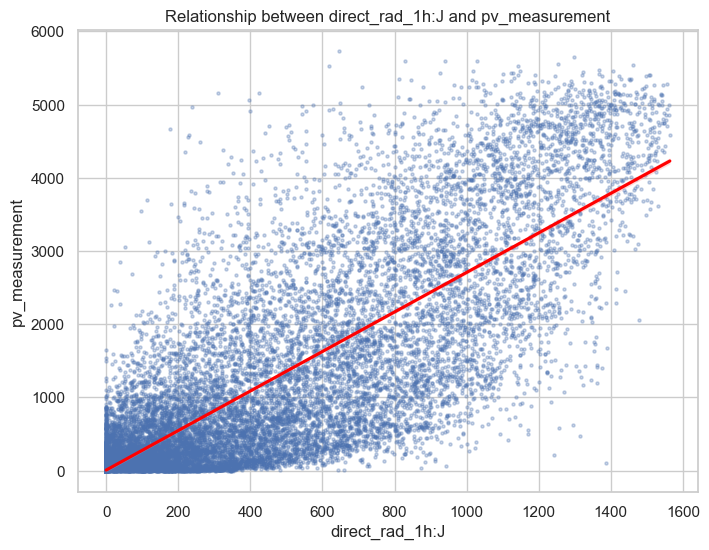

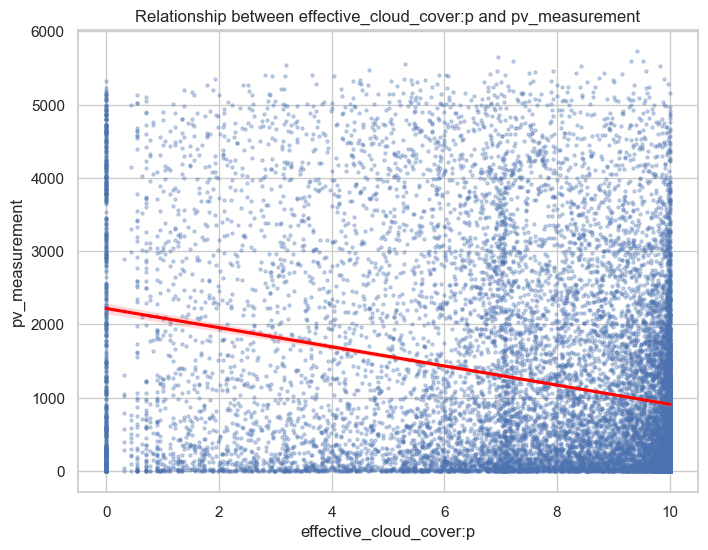

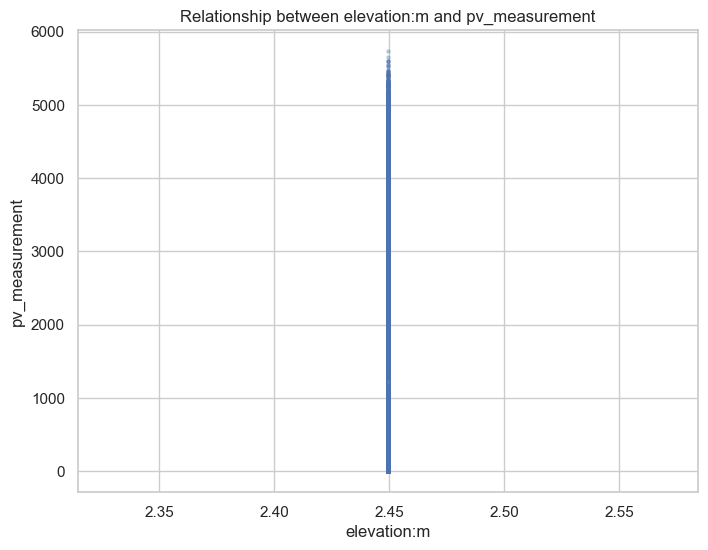

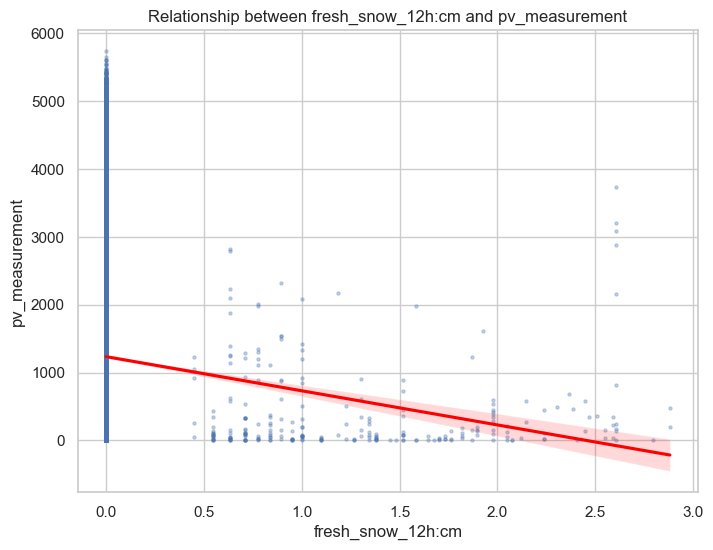

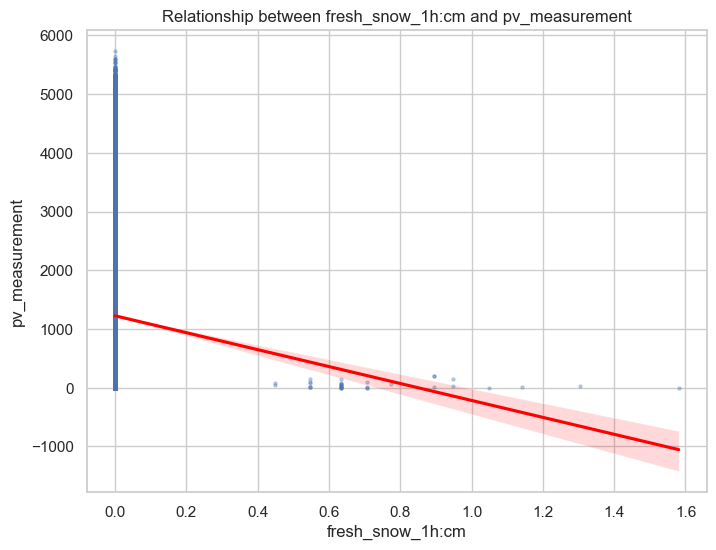

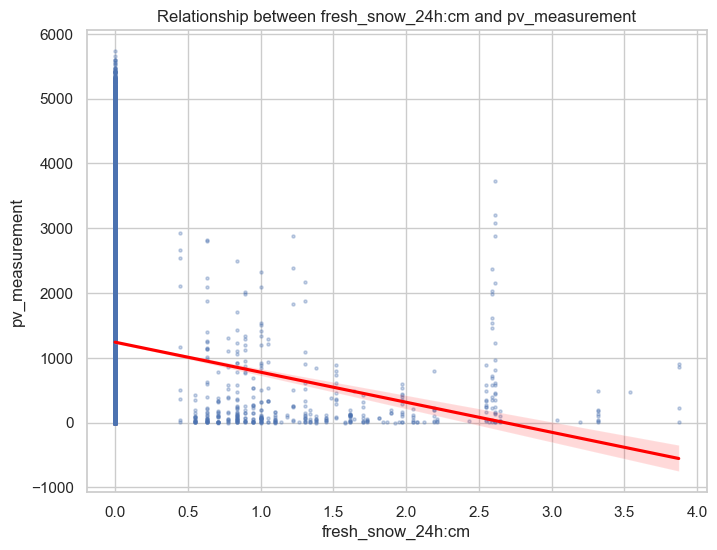

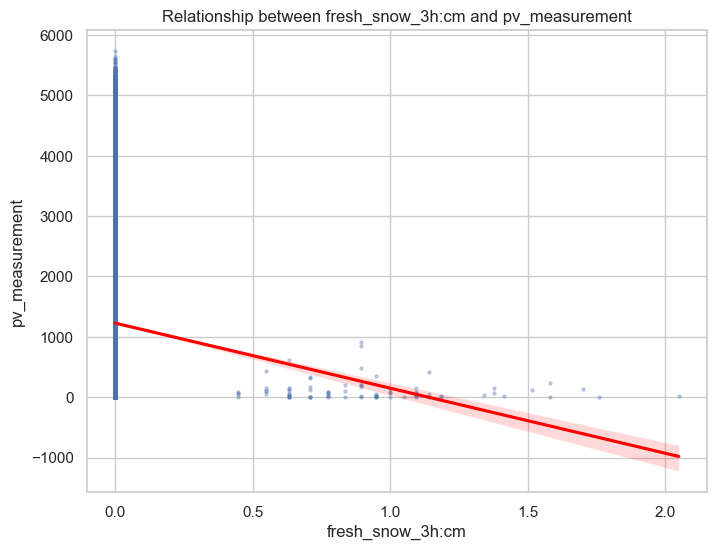

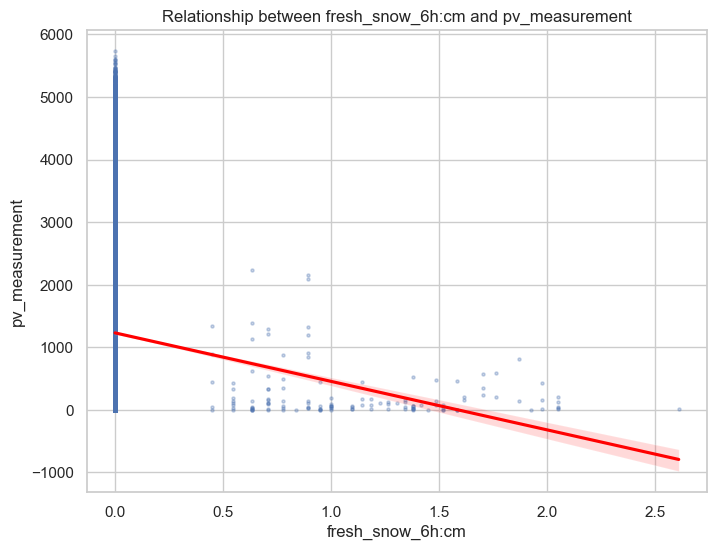

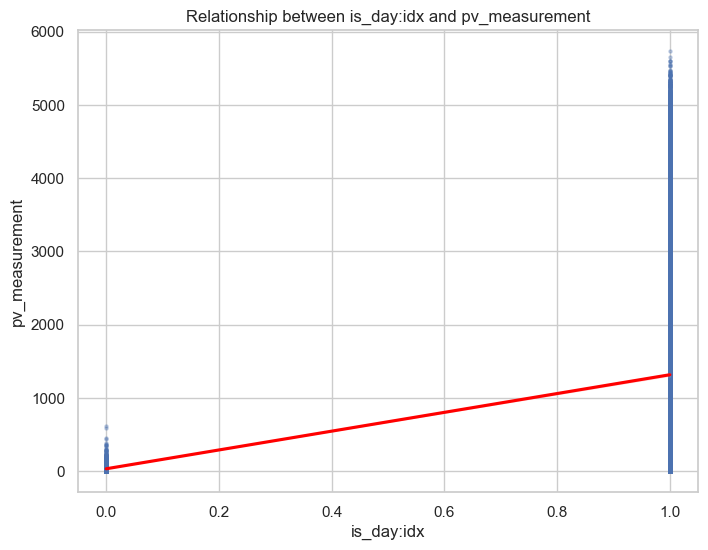

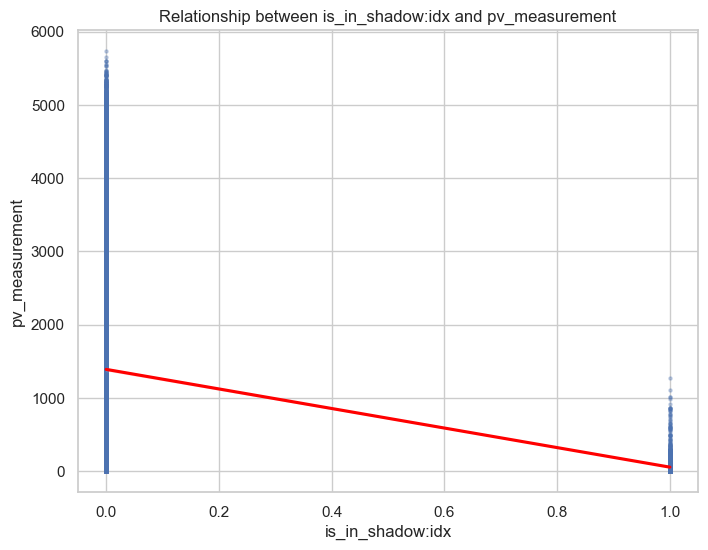

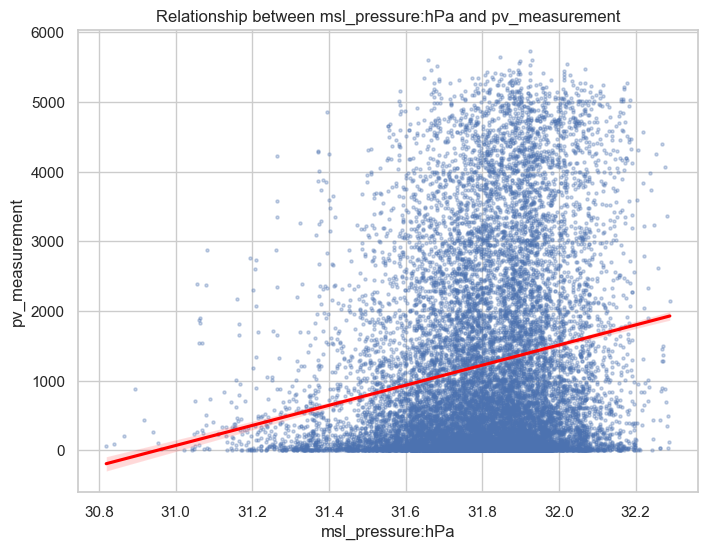

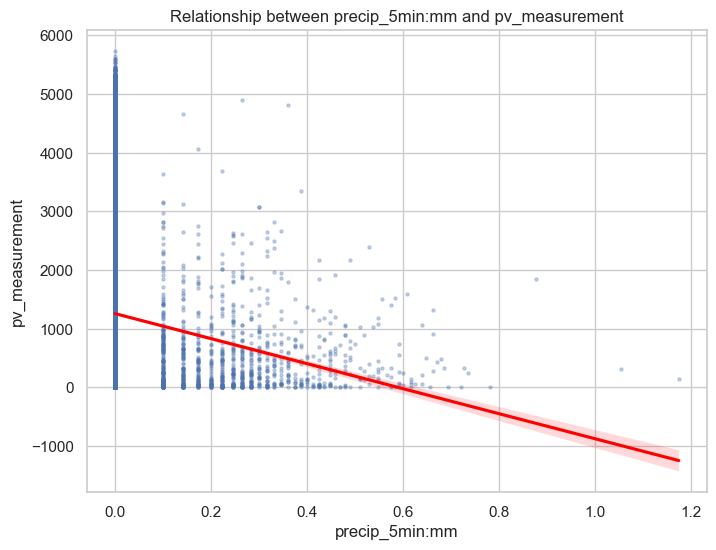

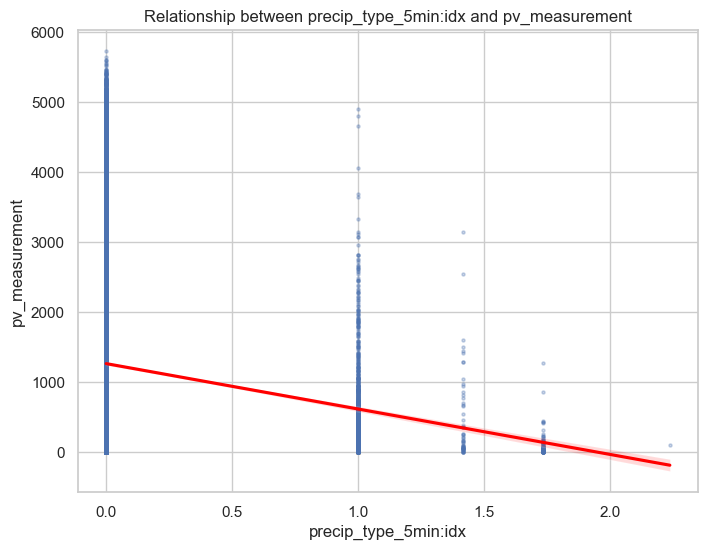

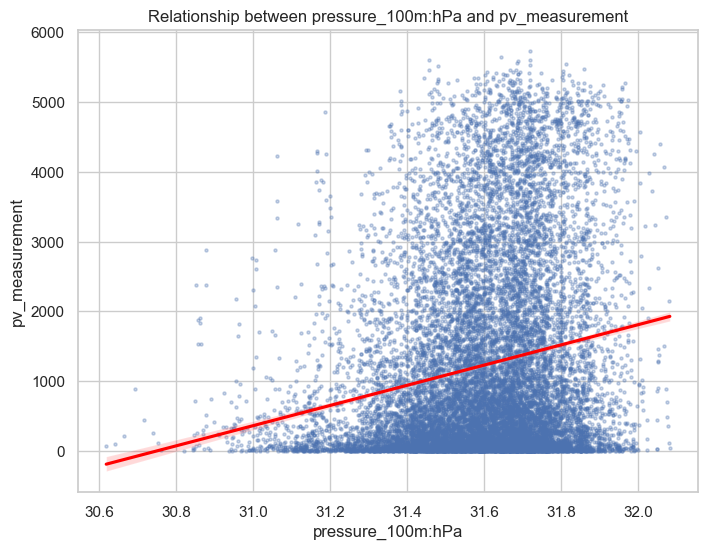

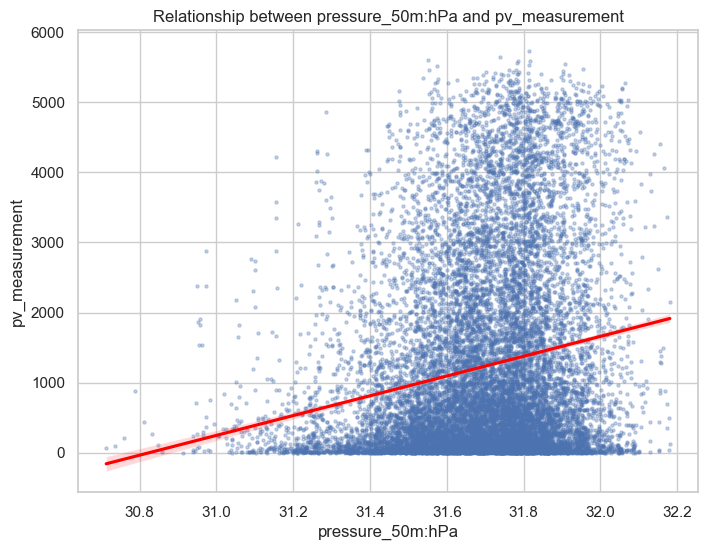

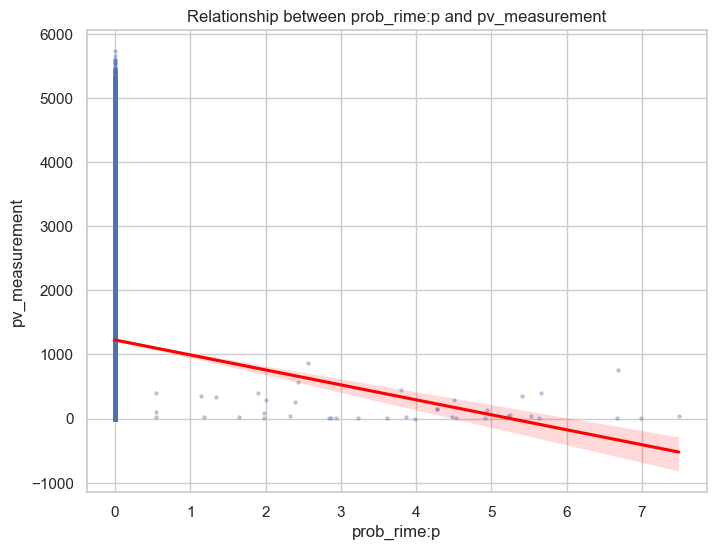

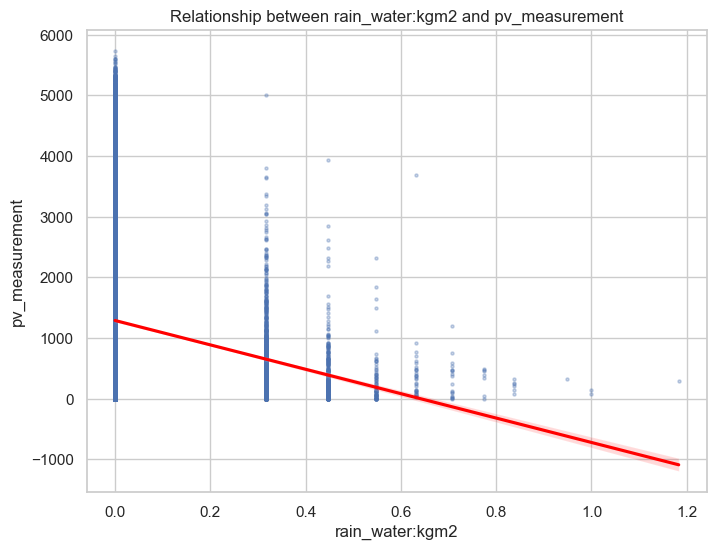

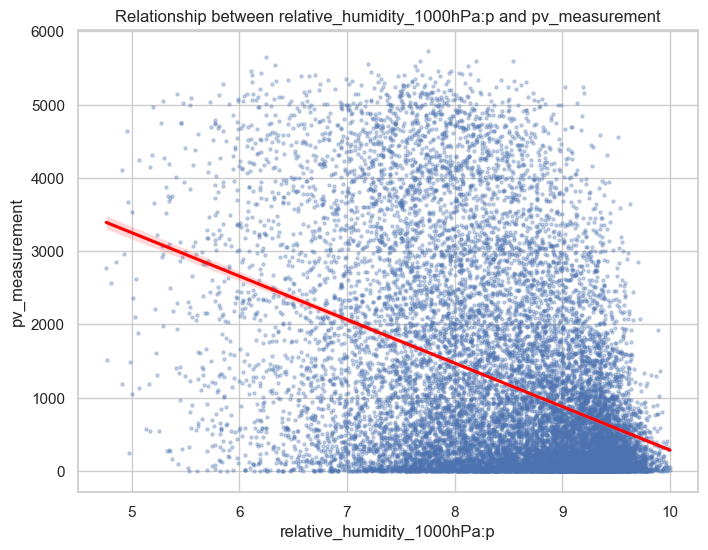

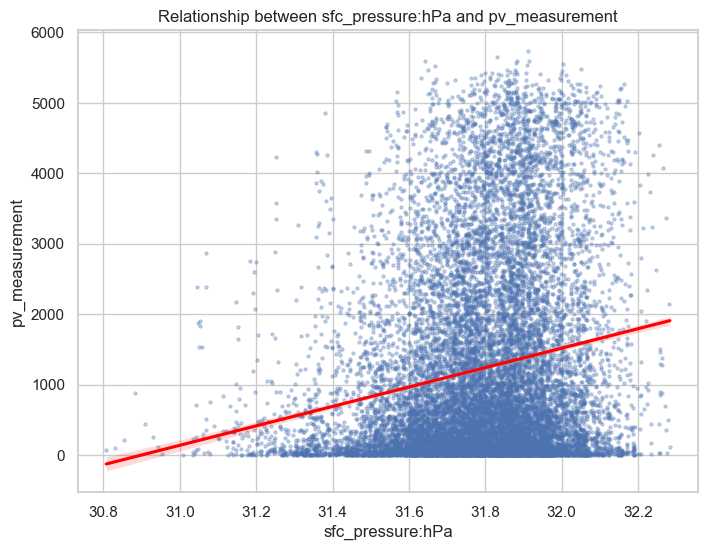

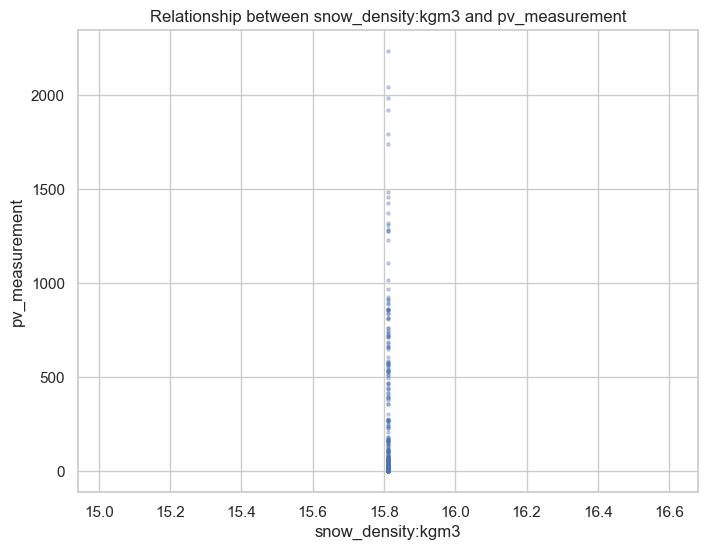

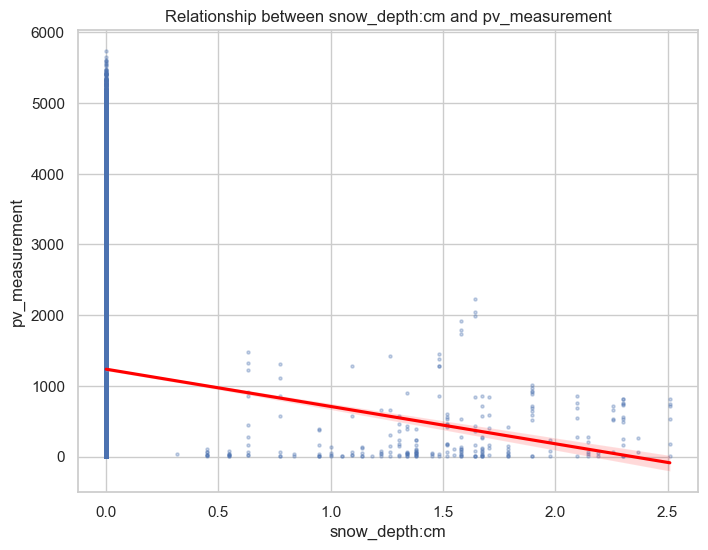

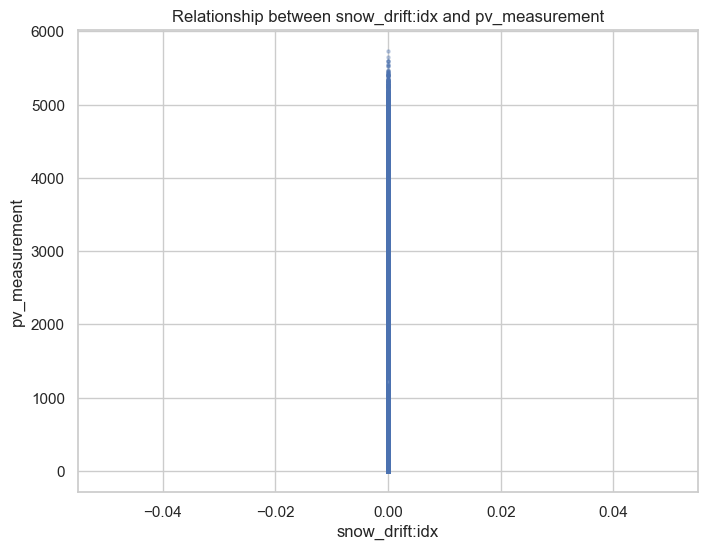

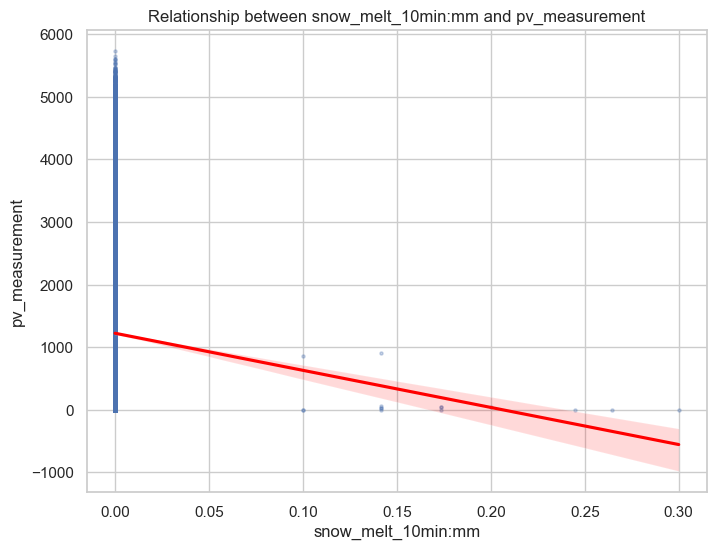

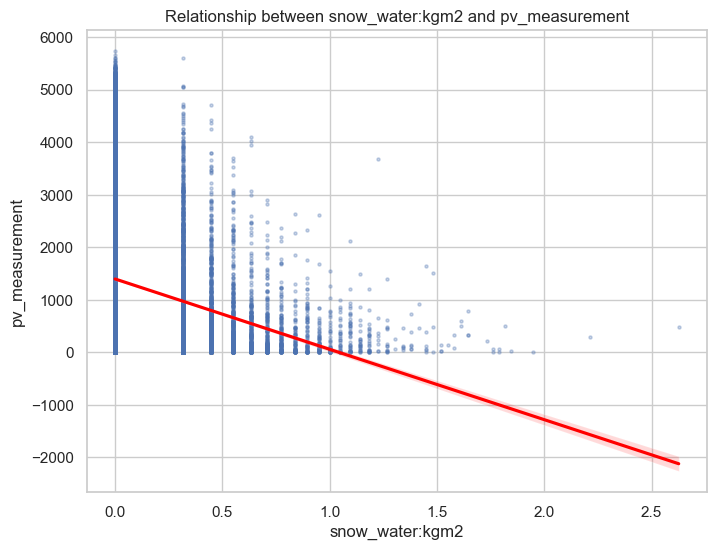

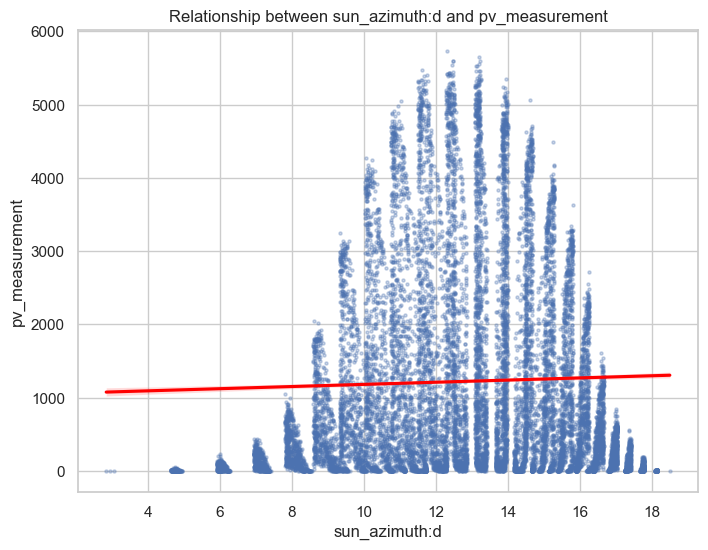

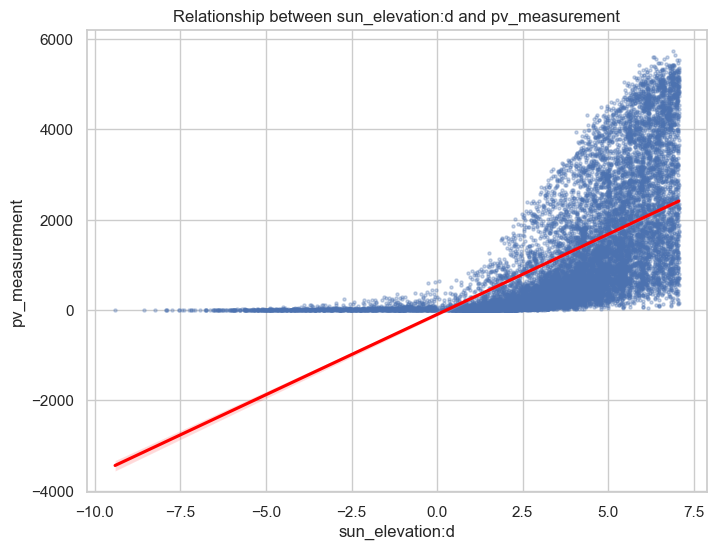

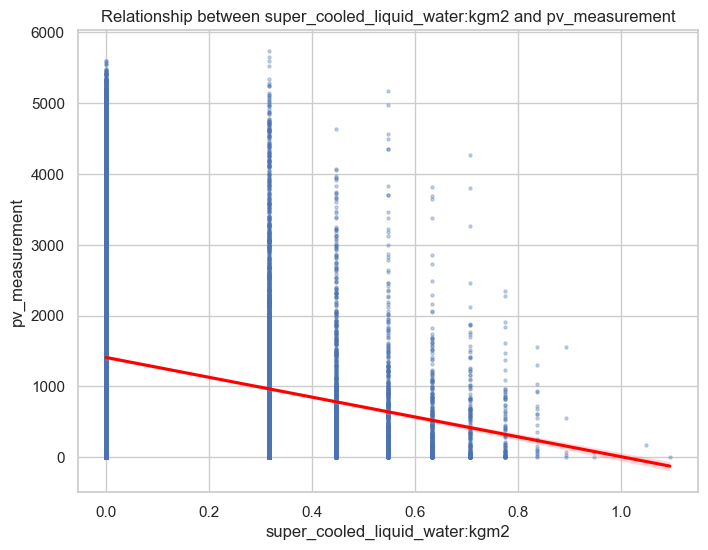

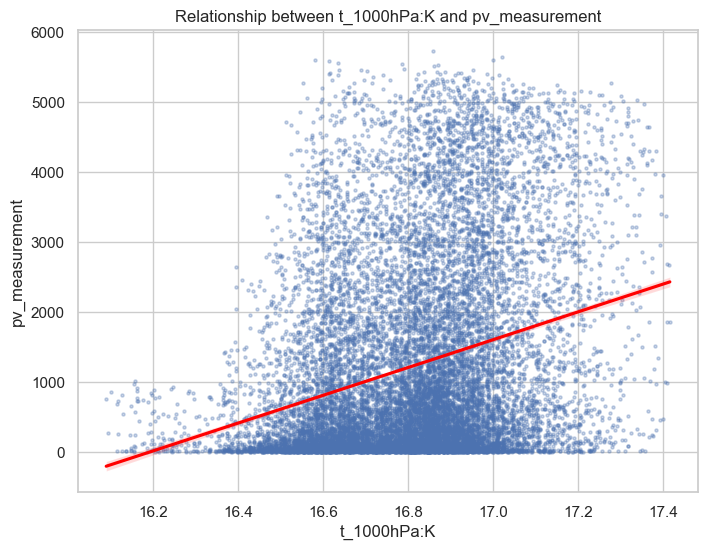

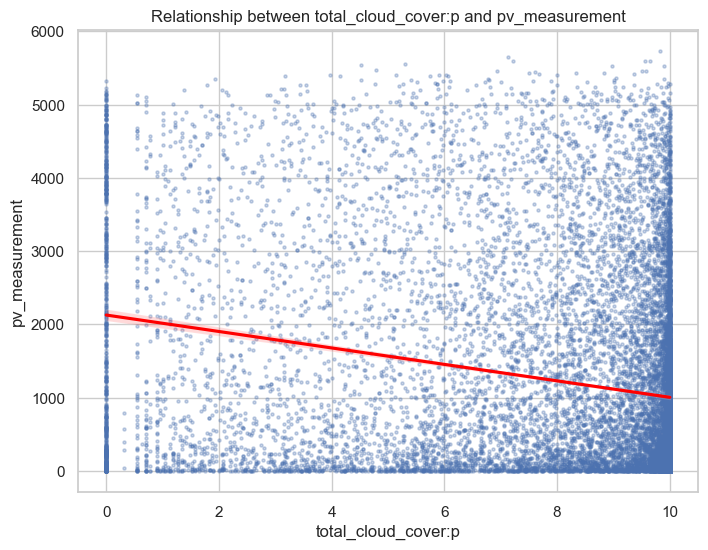

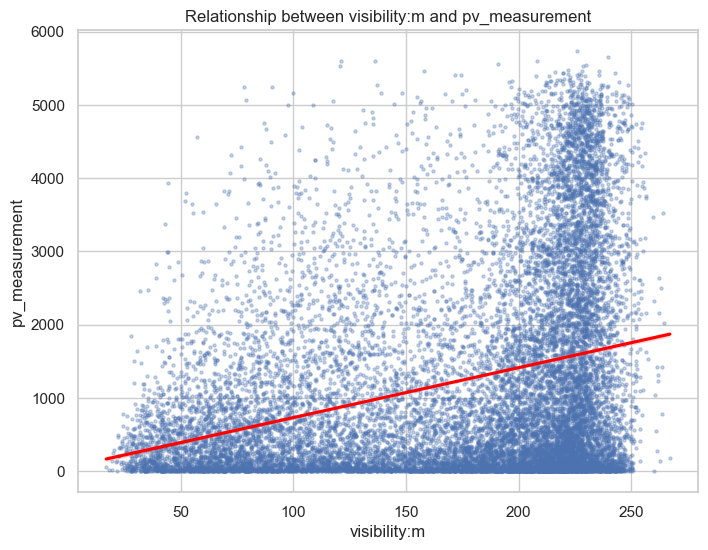

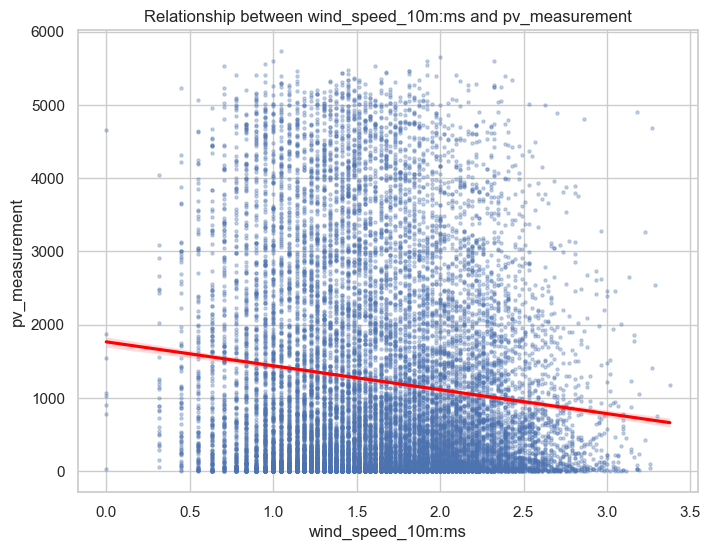

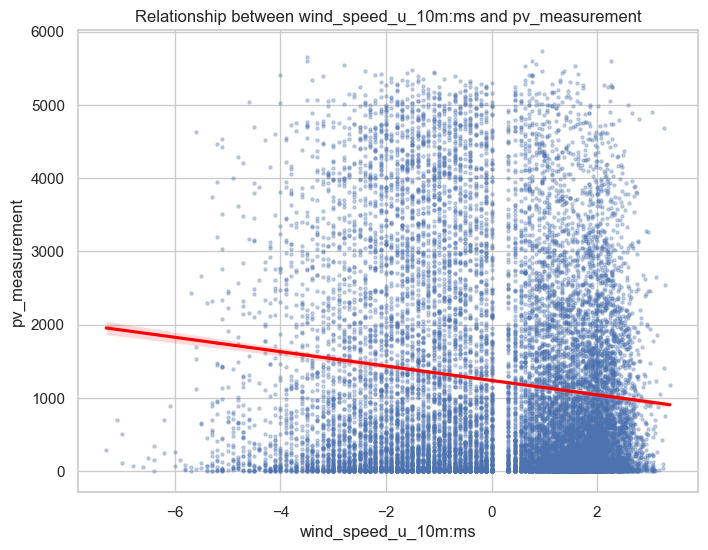

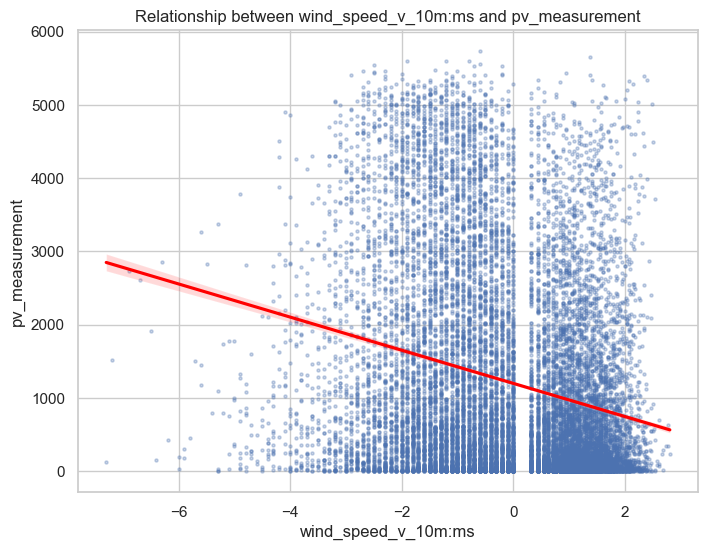

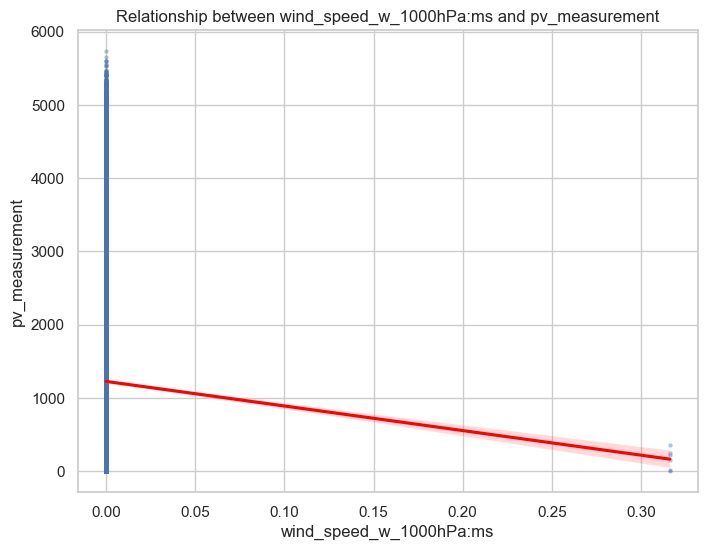

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
df_scaled_features, df_target = resize_training_data(X_observed_a, y_a)
target_column = 'pv_measurement'
df_features = df_scaled_features.map(lambda x: np.sqrt(x) if x > 0 else x)

# Adjusting the style of the plots
sns.set(style="whitegrid")

for feature in df_features.columns:
    plt.figure(figsize=(8, 6))
    
    # Creating a scatterplot with a regression line
    sns.regplot(x=df_features[feature], y=df_target[target_column], scatter_kws={'s':5, 'alpha':0.3}, line_kws={'color':'red'})
    
    # Adding titles and labels
    plt.title(f'Relationship between {feature} and {target_column}')
    plt.xlabel(feature)
    plt.ylabel(target_column)
    
    # Displaying the plot
    plt.show()

# Normalized scatterplots [-1,1]

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Assuming resize_training_data returns pandas DataFrames
df_scaled_features, df_target = resize_training_data(X_observed_a, y_a)

#scaler = MinMaxScaler(feature_range=(-1, 1))
#scaled_features = scaler.fit_transform(df_features)

#df_scaled_features = df_scaled_features.map(lambda x: np.sqt(x,3) if x > 0 else x)
df_scaled_features = df_scaled_features.map(lambda x: -np.power(x,2) if x > 0 else x)
# Converting scaled features from ndarray to DataFrame
#df_scaled_features = pd.DataFrame(scaled_features, columns=df_features.columns)

# Looping through each feature column in the DataFrame
for feature in df_scaled_features.columns:
    plt.figure(figsize=(6, 4))
    
    # Create a scatter plot for each feature vs the target
    plt.scatter(df_scaled_features[feature], df_target['pv_measurement'])
    
    # Adding title and labels
    plt.title(f'Scatterplot of {feature} vs pv_measurement')
    plt.xlabel(feature)
    plt.ylabel('pv_measurement')
    
    # Display the plot
    plt.show()


# PCA

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Assume df is your DataFrame, and target is what you want to predict
X, y = resize_training_data(X_observed_a, y_a)
y = y["pv_measurement"]
X.fillna(X.mean(), inplace=True)
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Applying PCA
pca = PCA(n_components=2)  # choose the number of components
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Now, you can use X_train_pca and X_test_pca for modeling

In [ ]:
df_features, df_target = resize_training_data(pd.concat([X_observed_a, X_estimated_a]), y_a)
def preprocess_data(df):
    # Handling missing values by filling them with the mean of each column
    df.fillna(df.mean(), inplace=True)
    
    # Replacing infinite values with NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Dropping rows that still have NaN values
    df.dropna(inplace=True)
    
    return df

# Preprocess both the feature and target DataFrames
df_features = preprocess_data(df_features.copy())
df_target = preprocess_data(df_target.copy())

# Ensure that the DataFrames have the same index
common_index = df_features.index.intersection(df_target.index)
df_features = df_features.loc[common_index]
df_target = df_target.loc[common_index]


In [ ]:
import itertools
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



def evaluate_combinations(X_df, y_df, target_column):
    X = X_df.copy()
    y = y_df[target_column].values
    
    # Splitting the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
    
    features = X.columns
    results = []
    
    for r in range(1, len(features)+1):
        # Creating combinations of features of length r
        for subset in itertools.combinations(features, r):
            selected_features = list(subset)
            
            # Fitting and evaluating the model
            model = LinearRegression().fit(X_train[selected_features], y_train)
            predictions = model.predict(X_test[selected_features])
            mae = mean_absolute_error(y_test, predictions)
            
            results.append({
                'features': selected_features,
                'mae': mae
            })
    
    # Converting results to DataFrame and sorting by mse
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='mae', ascending=True)
    
    return results_df

selected_features = ['direct_rad:W', 'direct_rad_1h:J', 'clear_sky_rad:W', 'clear_sky_energy_1h:J',
                 'diffuse_rad:W', 'diffuse_rad_1h:J', 'sun_elevation:d', 'is_in_shadow:idx', 'is_day:idx',
                 'relative_humidity_1000hPa:p', 't_1000hPa:K', 'sun_azimuth:d', 'fresh_snow_6h:cm']
df_features = df_features[selected_features]

# Run the function
results = evaluate_combinations(df_features, df_target, 'pv_measurement')

# Display the results
print(results)

In [ ]:
print(results)

In [ ]:
for i in range(10):
    print(results.iloc[i]["features"])